<a href="https://colab.research.google.com/github/carloslizarragac/FisicaComputacional1/blob/master/Actividad5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Feb 8, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# Para calcular las estacionalidad, tendencia y residuo 
import statsmodels.api as sm

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


In [2]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Guaymas26292.txt'
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/3061.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()
df_meteo.info()
print(df_meteo.head())
print(df_meteo.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29804 entries, 0 to 29803
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   29804 non-null  datetime64[ns]
 1   Precip  29786 non-null  float64       
 2   Evap    1389 non-null   float64       
 3   Tmax    29723 non-null  float64       
 4   Tmin    29724 non-null  float64       
 5   Año     29804 non-null  int64         
 6   Mes     29804 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.6+ MB
       Fecha  Precip  Evap  Tmax  Tmin   Año  Mes
0 1929-11-01     0.0   NaN  26.0  19.0  1929  Nov
1 1929-11-02     0.0   NaN  27.0  18.0  1929  Nov
2 1929-11-03     0.0   NaN  25.0  18.0  1929  Nov
3 1929-11-04     0.0   NaN  24.0  17.0  1929  Nov
4 1929-11-05     0.0   NaN  22.0  15.0  1929  Nov
           Fecha  Precip  Evap  Tmax  Tmin   Año  Mes
29799 2017-12-27     0.0   NaN  21.5  16.0  2017  Dec
29800 2

Creamos un **Serie de Tiempo**, fijando a la variable *'Fecha'* como nuevo índice del DataFrame. 

In [3]:
# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
print(df_meteo_ts.head())
print(df_meteo_ts.tail())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29804 entries, 1929-11-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  29786 non-null  float64
 1   Evap    1389 non-null   float64
 2   Tmax    29723 non-null  float64
 3   Tmin    29724 non-null  float64
 4   Año     29804 non-null  int64  
 5   Mes     29804 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.6+ MB
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
1929-11-01     0.0   NaN  26.0  19.0  1929  Nov
1929-11-02     0.0   NaN  27.0  18.0  1929  Nov
1929-11-03     0.0   NaN  25.0  18.0  1929  Nov
1929-11-04     0.0   NaN  24.0  17.0  1929  Nov
1929-11-05     0.0   NaN  22.0  15.0  1929  Nov
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
2017-12-27     0.0   NaN  21.5  16.0  2017  Dec
2017-12-28     0.0   NaN  24.5  17.0 

In [4]:
# Seleccionaremos un conjunto de años de 30 años  
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]


In [38]:
df_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1990-01-01,0.0,NaN,19.0,11.0,1990,Jan
1990-01-02,0.0,NaN,20.0,11.0,1990,Jan
1990-01-03,0.0,NaN,17.0,11.0,1990,Jan
1990-01-04,0.0,NaN,20.0,11.0,1990,Jan
1990-01-05,0.0,NaN,19.0,11.0,1990,Jan


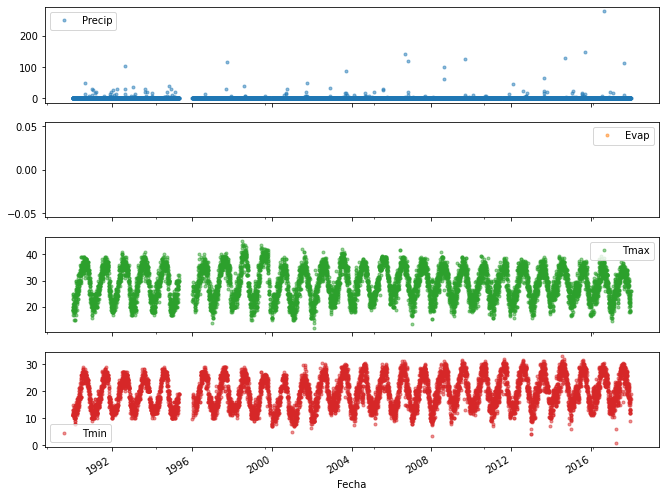

In [5]:
# Podemos visualizar la colección de los últimos 30 años y ver si hay datos faltantes.
cols_plot = ['Precip', 'Evap', 'Tmax', 'Tmin']
ax_ylabels = ['Precip (mm)', 'Evap (mm)', 'Tmax ºC', 'Tmin (ºC)']
axes = df_90[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', 
                                  figsize=(11, 9), subplots=True)


Variación en Precipitación promedio 60-30 : -0.2098196906644333
Variación en Precipitación promedio 90-60 : 0.13794780408490043


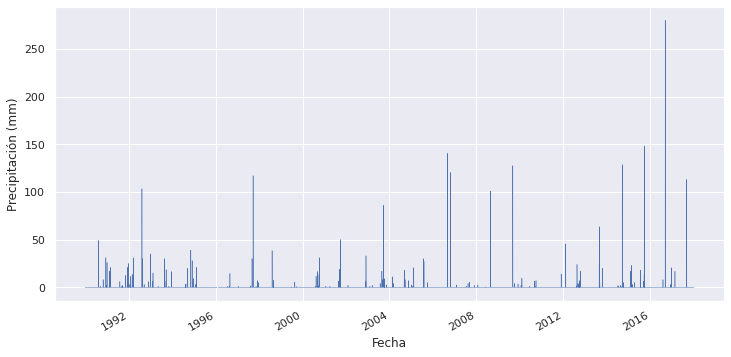

In [32]:
# Graficamos la Precipitación de los últimos 30 años (1990-hasta 2017)
# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})

# Calculamos algunos promedios de cada época de 30 años
Precip_ave_90 = df_90.Precip.mean()
Precip_ave_60 = df_60.Precip.mean()
Precip_ave_30 = df_30.Precip.mean()

# Graficamos la precipitación de la epoca 90 a la actualidad
df_90['Precip'].plot(linewidth=0.5);
plt.ylabel('Precipitación (mm)');

# Calculamos diferencias de los promedios de precipitación
print('Variación en Precipitación promedio 60-30 :', Precip_ave_60-Precip_ave_30)
print('Variación en Precipitación promedio 90-60 :', Precip_ave_90-Precip_ave_60)


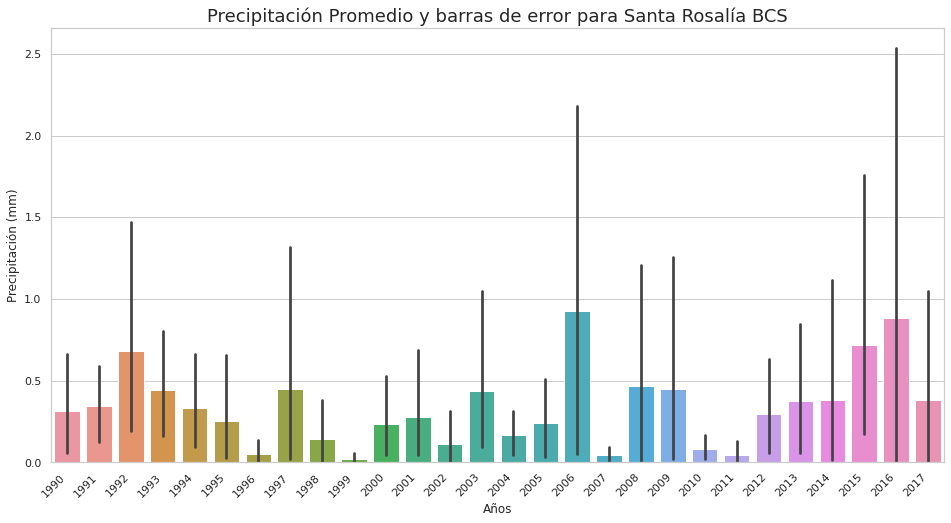

In [37]:
# Gráfica de Precipitación últimos 30 años
# Agrupada por Año
sns.set_style('whitegrid')

# Tamaño de la gráfica
plt.figure(figsize=(16,8))

# Graficamos 30 años de datos usando la columna 'Año' en el eje x
g =sns.barplot(x='Año', y='Precip', data=df_90);

# Rotamos 45º los Años en el eje x para mejor lectura
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

plt.xlabel('Años')
plt.ylabel('Precipitación (mm)')
plt.title('Precipitación Promedio y barras de error para Santa Rosalía BCS', fontsize=18)

plt.show()

Variación ºC Tmax promedio 90s-60s : 0.21684203258373813


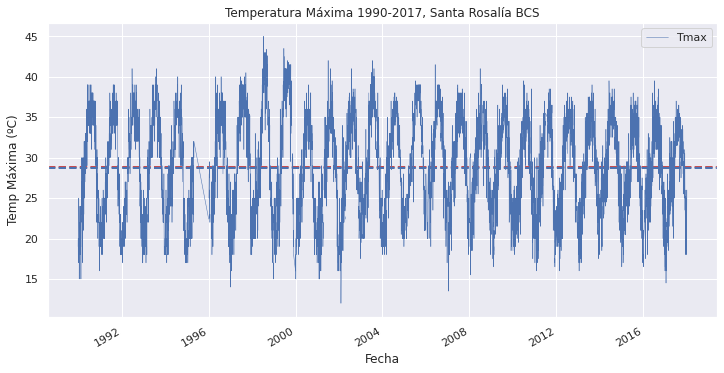

In [ ]:
# Graficamos la Tmax de los últimos 30 años (1990-hasta 2017)

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})

# Cálculo de promedios
Tmax_ave_90 = df_90.Tmax.mean()
Tmax_ave_60 = df_60.Tmax.mean()

# Graficar líneas promedios (rojo 1990-2017, azul 1960-1989)
plt.axhline(Tmax_ave_90, color = 'r', linestyle='--', linewidth=2);
plt.axhline(Tmax_ave_60, color = 'b', linestyle='--', linewidth=2);

# Graficar la Temperatura
df_90['Tmax'].plot(linewidth=0.5);
plt.ylabel('Temp Máxima (ºC)');
plt.title('Temperatura Máxima 1990-2017, Santa Rosalía BCS')

plt.legend();

# Imprime la diferencia de Temperaturas promedio entre épocas 
print('Variación ºC Tmax promedio 90s-60s :', Tmax_ave_90-Tmax_ave_60)


Variación ºC Tmin promedio 90s-60s : 1.0847311713890448


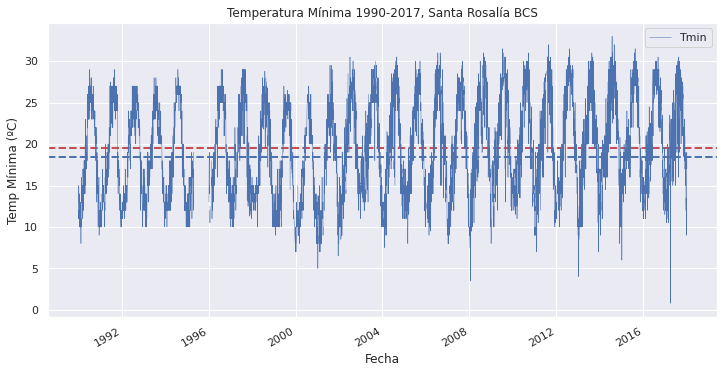

In [ ]:
# Hacemos lo mismo que la gráfica anterior con la Tmin
# Graficamos la Tmin de los últimos 30 años (1990-hasta 2017)
sns.set(rc={'figure.figsize':(12, 6)})

Tmin_ave_90 = df_90.Tmin.mean()
Tmin_ave_60 = df_60.Tmin.mean()

plt.axhline(Tmin_ave_90, color = 'r', linestyle='--', linewidth=2);
plt.axhline(Tmin_ave_60, color = 'b', linestyle='--', linewidth=2);

df_90['Tmin'].plot(linewidth=0.5);
plt.ylabel('Temp Mínima (ºC)');
plt.title('Temperatura Mínima 1990-2017, Santa Rosalía BCS')

plt.legend();



print('Variación ºC Tmin promedio 90s-60s :', Tmin_ave_90-Tmin_ave_60)


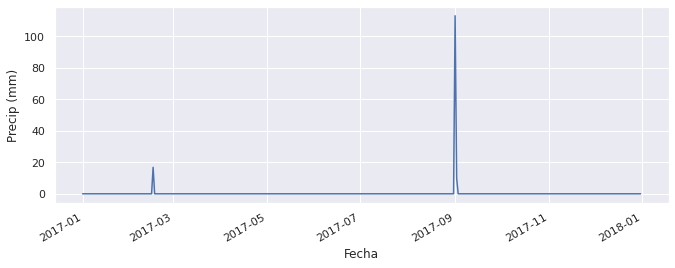

In [ ]:
# Investigando un año de datos, usando la función df.loc() para filtrar un periodo
ax = df_90.loc['2017', 'Precip'].plot()
ax.set_ylabel('Precip (mm)');


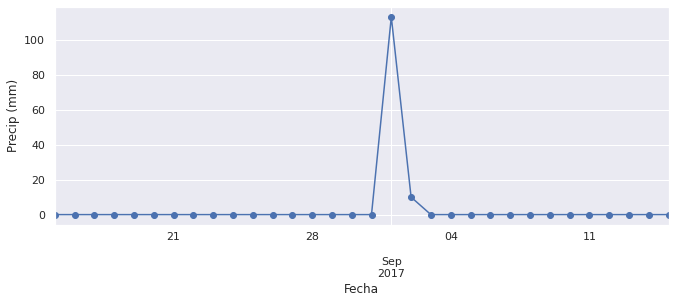

In [ ]:
# Investigando un periodo de datos con df.loc()
ax = df_90.loc['2017-08-15':'2017-09-15', 'Precip'].plot(marker='o', linestyle='-')
ax.set_ylabel('Precip (mm)');


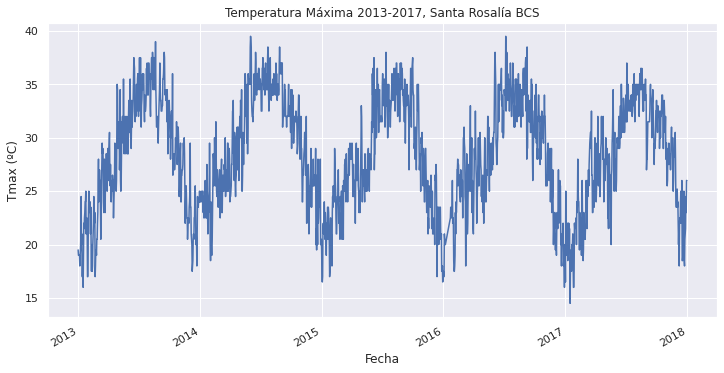

In [ ]:
# Investigando un rango de datos
sns.set(rc={'figure.figsize':(12, 6)})

ax = df_90.loc['2013':'2017', 'Tmax'].plot()
ax.set_ylabel('Tmax (ºC)');
ax.set_title('Temperatura Máxima 2013-2017, Santa Rosalía BCS');


In [6]:
# Suavizando la curva de Tmax, utilizando Promedios Móviles (7,30 y 365 días)
data_cols = ['Evap', 'Tmax', 'Tmin']
df_90_7d = df_90[data_cols].rolling(7, center=True).mean()
df_90_30d = df_90[data_cols].rolling(30, center=True).mean()
df_90_365d = df_90[data_cols].rolling(365, center=True).mean() 


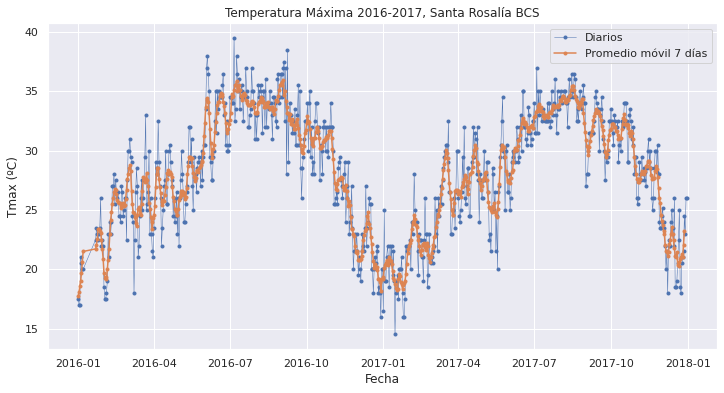

In [ ]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2016-01', '2017-12'

# Contraste de la gráfica de datos diarios y la de promedio móvil de 7 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_90.loc[start:end, 'Tmax'],
marker='.', linestyle='-', linewidth=0.5, label='Diarios')
ax.plot(df_90_7d.loc[start:end, 'Tmax'], marker='.', linestyle='-', label='Promedio móvil 7 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Tmax (ºC)')
ax.set_title('Temperatura Máxima 2016-2017, Santa Rosalía BCS')
ax.legend();


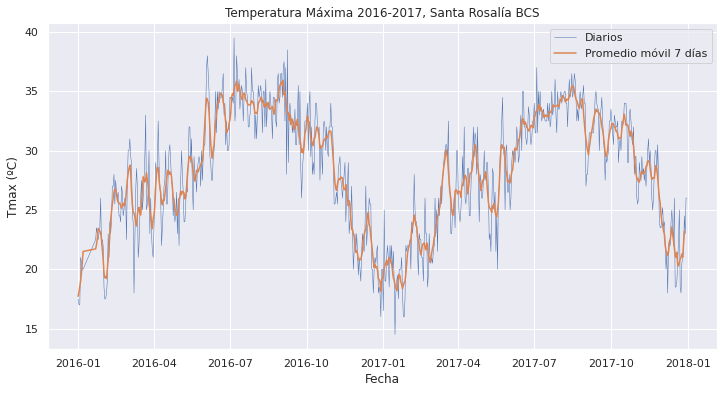

In [ ]:
# Misma gráfica anterior pero sin marcadores '.'
# Fechas de inicio y fin, para filtrar la información
start, end = '2016-01', '2017-12'

# Contraste de la gráfica de datos diarios y la de promedio móvil de 7 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_90.loc[start:end, 'Tmax'],
linestyle='-', linewidth=0.5, label='Diarios')
ax.plot(df_90_7d.loc[start:end, 'Tmax'], linestyle='-', label='Promedio móvil 7 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Tmax (ºC)')
ax.set_title('Temperatura Máxima 2016-2017, Santa Rosalía BCS')
ax.legend();


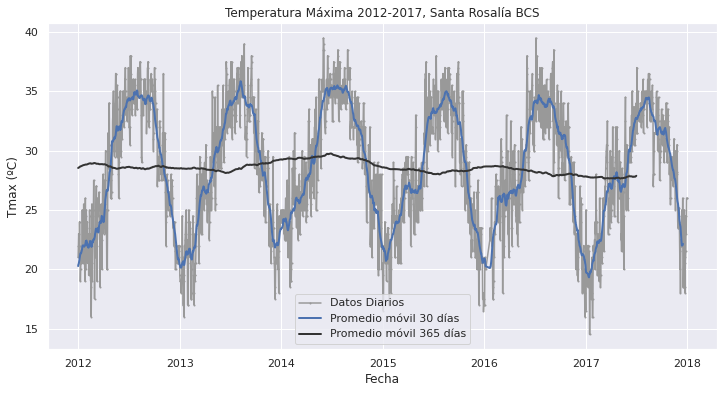

In [ ]:
# Tendencias ... año con año

# Fechas de inicio y fin, para filtrar la información
start, end = '2012-01', '2017-12'

# Contraste de la gráfica de datos diarios y promedio móvil de 30 y 365 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_90.loc[start:end, 'Tmax'],
marker='.', markersize=2, linestyle='-', color='0.6',label='Datos Diarios')
#ax.plot(df_90_7d.loc[start:end, 'Tmax'], linestyle='-', label='Promedio móvil 7 días')
ax.plot(df_90_30d.loc[start:end, 'Tmax'], linestyle='-', linewidth=2, label='Promedio móvil 30 días')
ax.plot(df_90_365d.loc[start:end, 'Tmax'], linestyle='-', color='0.2', linewidth=2, label='Promedio móvil 365 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Tmax (ºC)')
ax.set_title('Temperatura Máxima 2012-2017, Santa Rosalía BCS')
ax.legend();



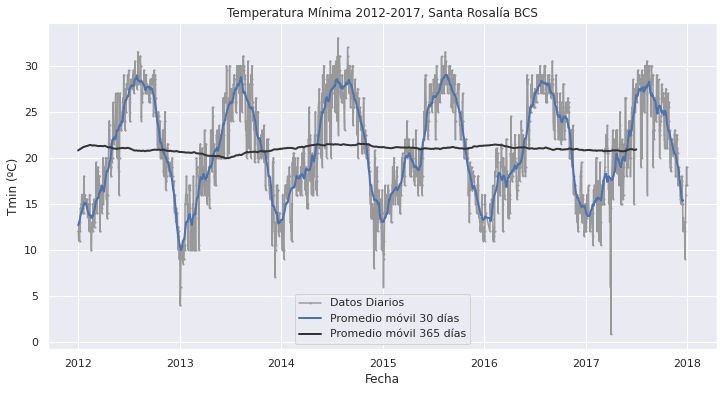

In [ ]:
# Tendencias ... año con año para Tmin

# Fechas de inicio y fin, para filtrar la información
start, end = '2012-01', '2017-12'

# Contraste de la gráfica de datos diarios y promedio móvil de 30 y 365 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_90.loc[start:end, 'Tmin'],
marker='.', markersize=2, linestyle='-', color='0.6',label='Datos Diarios')
#ax.plot(df_90_7d.loc[start:end, 'Tmin'], linestyle='-', label='Promedio móvil 7 días')
ax.plot(df_90_30d.loc[start:end, 'Tmin'], linestyle='-', linewidth=2, label='Promedio móvil 30 días')
ax.plot(df_90_365d.loc[start:end, 'Tmin'], linestyle='-', color='0.2', linewidth=2, label='Promedio móvil 365 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Tmin (ºC)')
ax.set_title('Temperatura Mínima 2012-2017, Santa Rosalía BCS')
ax.legend();


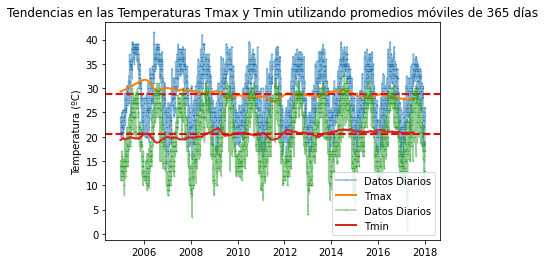

In [7]:
# Graficas de promedios móviles de 365 días para las variables de las Temperaturas  
start, end = '2005-01', '2017-12'

fig, ax = plt.subplots()
for nm in ['Tmax', 'Tmin']:
    ax.plot(df_90.loc[start:end, nm], marker='.', markersize=1, linestyle='-', alpha=0.5, label='Datos Diarios')
    ax.plot(df_90_365d.loc[start:end, nm], linewidth=2, label=nm)
    plt.axhline(df_90.loc[start:end, nm].mean(), color = 'r', linestyle='--', linewidth=2);
    
    ax.legend()
    ax.set_ylabel('Temperatura (ºC)')
    ax.set_title('Tendencias en las Temperaturas Tmax y Tmin utilizando promedios móviles de 365 días');


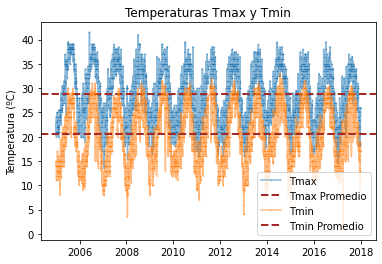

In [20]:
#Graficas de Temperaturas Tmax, Tmin y Promedios  
start, end = '2005-01', '2017-12'

fig, ax = plt.subplots()
for nm in ['Tmax', 'Tmin']:
    ax.plot(df_90.loc[start:end, nm], marker='.', markersize=1, linestyle='-', 
            alpha=0.5, label=nm)
    plt.axhline(df_90.loc[start:end, nm].mean(), color='brown', linestyle='--', 
                linewidth=2, label=nm + ' Promedio');
    
    ax.legend()
    ax.set_ylabel('Temperatura (ºC)')
    ax.set_title('Temperaturas Tmax y Tmin');
  

In [27]:
df_90_365d.info()
print(df_90_365d.head(185))
print(df_90_365d.tail(185))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9659 entries, 1990-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Evap    0 non-null      float64
 1   Tmax    6505 non-null   float64
 2   Tmin    6503 non-null   float64
dtypes: float64(3)
memory usage: 621.8 KB
            Evap       Tmax       Tmin
Fecha                                 
1990-01-01   NaN        NaN        NaN
1990-01-02   NaN        NaN        NaN
1990-01-03   NaN        NaN        NaN
1990-01-04   NaN        NaN        NaN
1990-01-05   NaN        NaN        NaN
...          ...        ...        ...
1990-06-30   NaN        NaN        NaN
1990-07-01   NaN        NaN        NaN
1990-07-02   NaN  29.252055  18.561644
1990-07-03   NaN  29.254795  18.561644
1990-07-04   NaN  29.254795  18.564384

[185 rows x 3 columns]
            Evap       Tmax       Tmin
Fecha                                 
2017-06-30   NaN  27.835068  20.874795
2

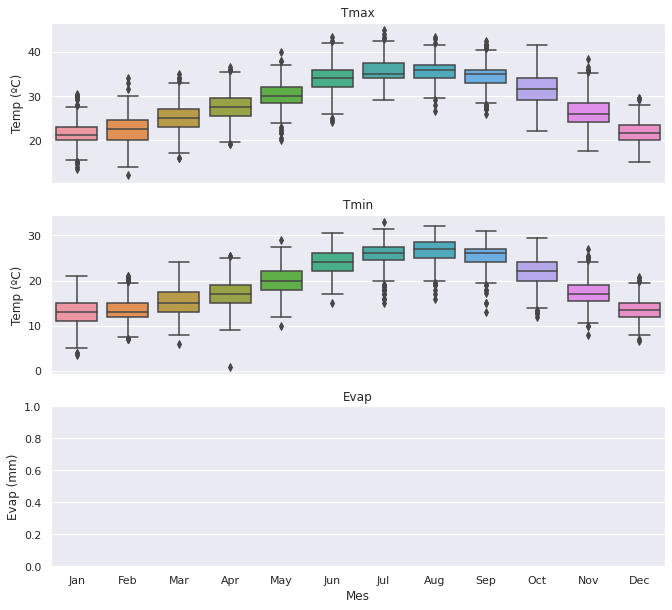

In [ ]:
# Analizando Estacionalidad de los datos, similar a lo que ya hicimos anteriormente.
# Dos gráficas en una
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

for name, ax in zip(['Tmax', 'Tmin', 'Evap'], axes):
  sns.boxplot(data=df_90, x='Mes', y=name, ax=ax)
  if name != 'Evap':
    ax.set_ylabel('Temp (ºC)')
  else: 
    ax.set_ylabel('Evap (mm)')
  ax.set_title(name)
# Elimina la etiqueta del eje x excepto la de la subgráfica de abajo 
  if ax != axes[-1]:
    ax.set_xlabel('')


**Análisis de Tendencia de Tmax** usando *statsmodel* 

Temp observada = Tendencia + Estacionalidad + Residuo

(res.resid, 
res.seasonal,
res.trend)

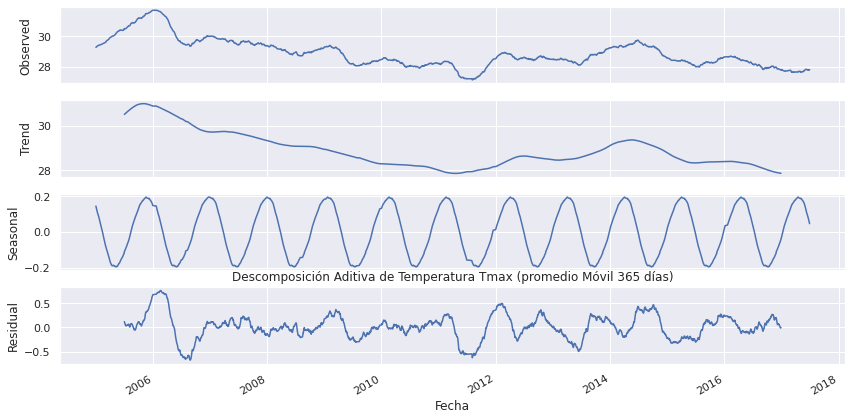

In [60]:
# Caso: Uso de datos con promedio móvil de 365 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2005-01', '2017-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmax = sm.tsa.seasonal_decompose(df_90_365d.loc[start:end, 'Tmax'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Tmax (promedio Móvil 365 días)');


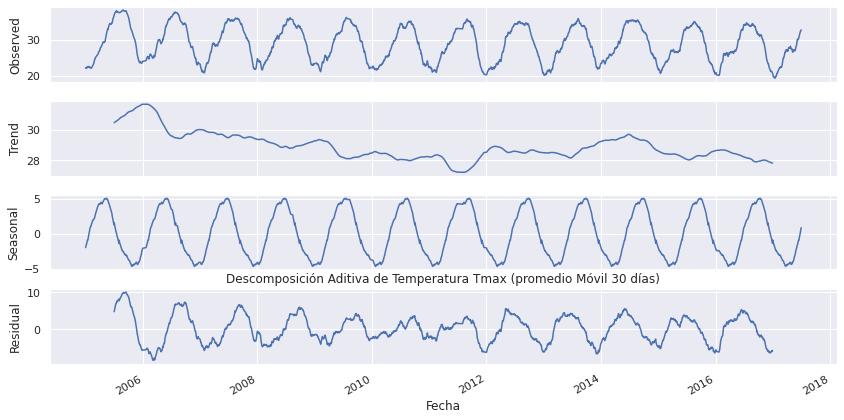

In [61]:
# Caso: Uso de datos con promedio móvil de 30 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2005-01', '2017-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmax = sm.tsa.seasonal_decompose(df_90_30d.loc[start:end, 'Tmax'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Tmax (promedio Móvil 30 días)');

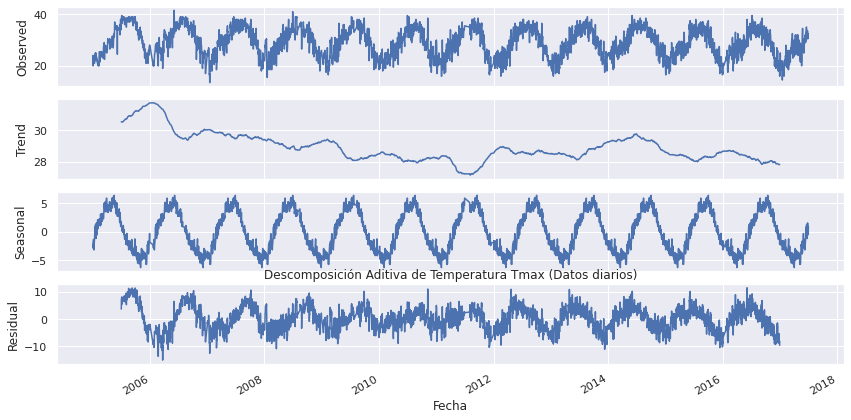

In [62]:
# Caso: Uso de datos diarios 
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2005-01', '2017-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmax = sm.tsa.seasonal_decompose(df_90.loc[start:end, 'Tmax'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Tmax (Datos diarios)');

**Análisis de Tendencia de Tmin** 

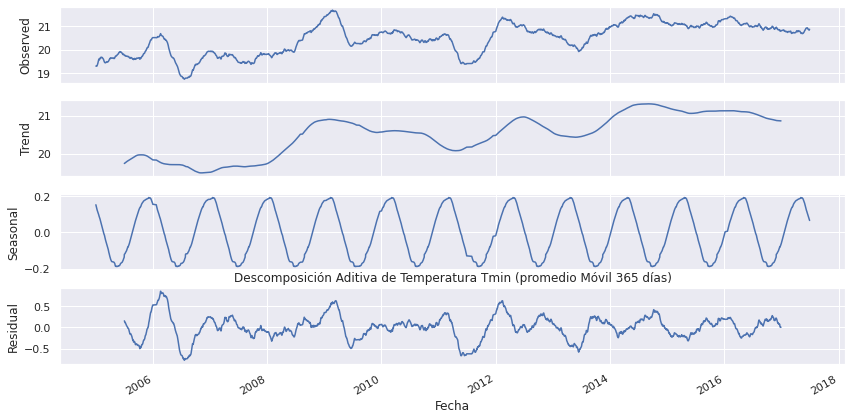

In [63]:
# Caso: Uso de datos con promedio móvil de 365 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2005-01', '2017-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 

resTmin = sm.tsa.seasonal_decompose(df_90_365d.loc[start:end, 'Tmin'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmin.plot()

plt.title('Descomposición Aditiva de Temperatura Tmin (promedio Móvil 365 días)');


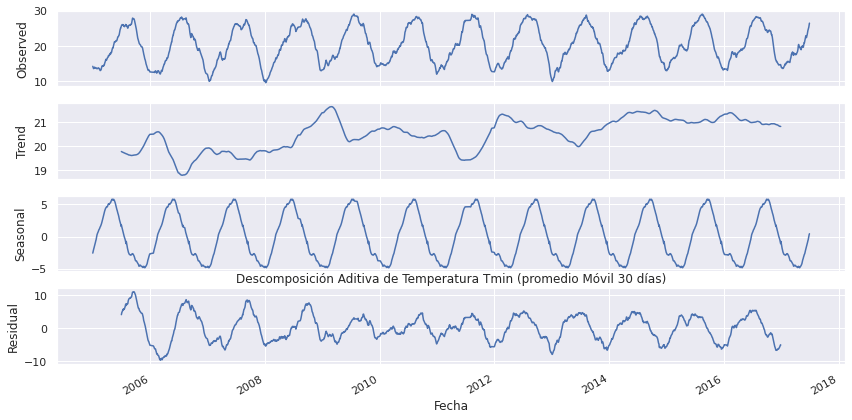

In [64]:
# Caso: Uso de datos con promedio móvil de 30 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2005-01', '2017-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 

resTmin = sm.tsa.seasonal_decompose(df_90_30d.loc[start:end, 'Tmin'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmin.plot()

plt.title('Descomposición Aditiva de Temperatura Tmin (promedio Móvil 30 días)');


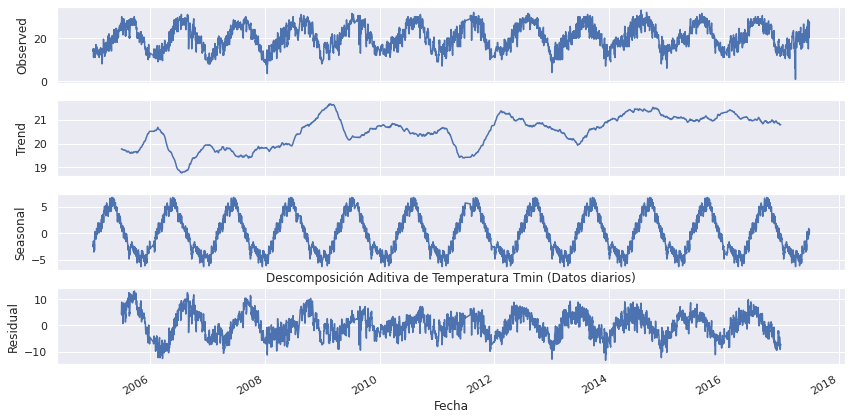

In [65]:
# Caso: Uso de datos diarios.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2005-01', '2017-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 

resTmin = sm.tsa.seasonal_decompose(df_90.loc[start:end, 'Tmin'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmin.plot()

plt.title('Descomposición Aditiva de Temperatura Tmin (Datos diarios)');


In [69]:
resTmax.trend.describe() 

count    4046.000000
mean       28.902184
std         0.882215
min        27.147945
25%        28.289384
50%        28.658219
75%        29.394521
max        31.723288
Name: Tmax, dtype: float64